## Fit the Heights of Two Peaks

Assume we have two components A and B -- a signal peak over a flat background -- and measure their sum. We know the shape and location of both, but we are interested in the relative contributions from either component:
if we see 1000 events, how many of them are generated by process A and B, respectively?


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel

Generate some pseudodata.

In [2]:
np.random.seed(42)
pdf_a = stats.halfcauchy(loc=0, scale=1)
pdf_b = stats.uniform(loc=0, scale=100)

n_a = 30
n_b = 1000

X = np.concatenate([
    pdf_a.rvs(size=n_a),
    pdf_b.rvs(size=n_b),
])[:, np.newaxis]

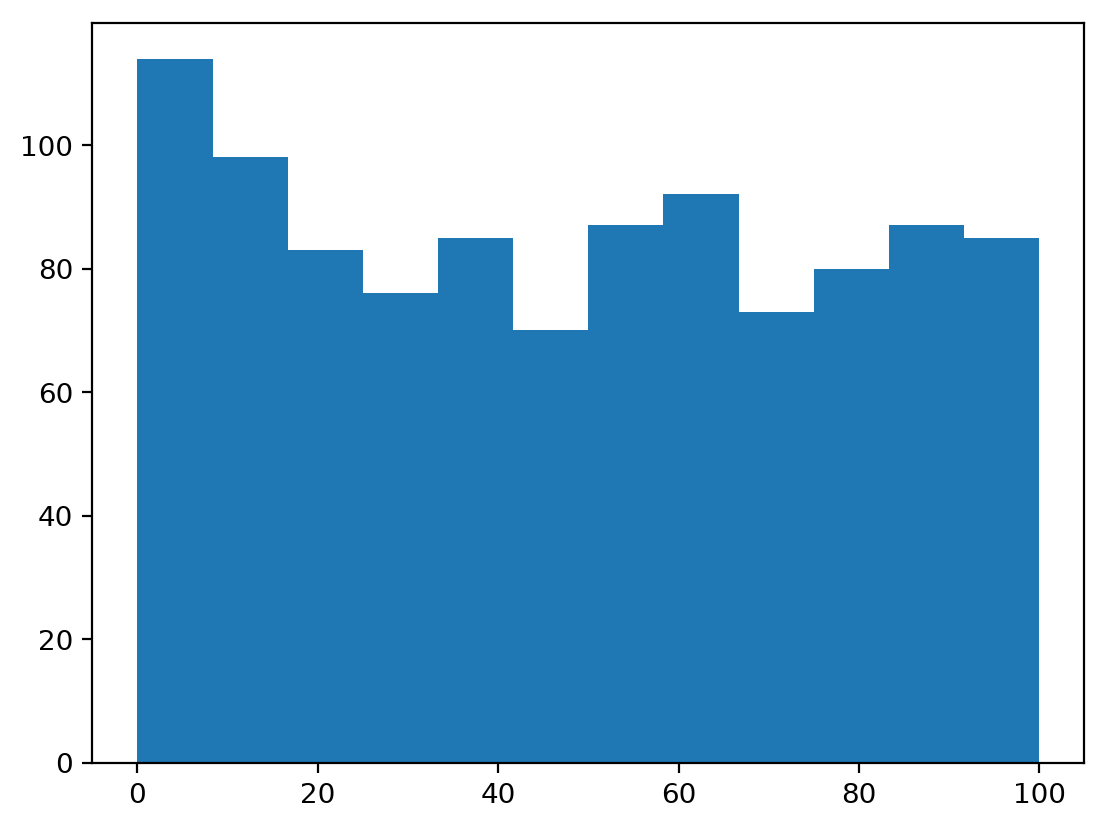

In [3]:
plt.hist(X, bins='auto');

We use a custom MLE here, without exogenous variables.

In [4]:
class TwoPeakLLH(GenericLikelihoodModel):
    """Fit height of signal peak over background."""
    start_params = [10, 1000]
    cloneattr = ['start_params', 'signal', 'background']
    exog_names = ['n_signal', 'n_background']
    endog_names = ['alpha']
    
    def __init__(self, endog, exog=None, signal=None, background=None,
                 *args, **kwargs):
        # assume we know the shape + location of the two components,
        # so we re-use their PDFs here
        self.signal = signal
        self.background = background
        super(TwoPeakLLH, self).__init__(endog=endog, exog=exog, 
                                         *args, **kwargs)

    def loglike(self, params):        # pylint: disable=E0202
        return -self.nloglike(params)

    def nloglike(self, params):
        endog = self.endog
        return self.nlnlike(params, endog)

    def nlnlike(self, params, endog):
        n_sig = params[0]
        n_bkg = params[1]
        if (n_sig < 0) or n_bkg < 0:
            return np.inf
        n_tot = n_bkg + n_sig
        alpha = endog
        sig = self.signal.pdf(alpha)
        bkg = self.background.pdf(alpha)
        sumlogl = np.sum(
            np.ma.log(
                (n_sig * sig) + (n_bkg * bkg)
            )
        )
        sumlogl -= n_tot
        return -sumlogl

In [5]:
model = TwoPeakLLH(endog=X, 
                   signal=pdf_a, 
                   background=pdf_b, 
                   )

In [6]:
res = model.fit()
_ = res.bootstrap()

Optimization terminated successfully.
         Current function value: -1.342181
         Iterations: 75
         Function evaluations: 143


In [7]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              TwoPeakLLH Results                              
==============================================================================
Dep. Variable:              ['alpha']   Log-Likelihood:                 1382.4
Model:                     TwoPeakLLH   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Tue, 22 May 2018                                         
Time:                        01:08:48                                         
No. Observations:                1030                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
n_signal        31.7378      8.912      3.561      0.000      14.270      49.206
n_background   998.2622     32.341     30.867      0.000     934.875    1061.650
================================================================================
"""